IMPORTS, LOADING, AND PREPROCESSING

In [124]:
# import libraries
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [125]:
# check PyTorch and GPU setup
print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

PyTorch Version: 2.5.1+cu124
CUDA Available: True
GPU Name: NVIDIA L4


In [126]:
# preprocessing transformation
# convert images to PyTorch tensors
# added augumentations to simulate more variations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

In [127]:
# load cifar-10 dataset
# partition into train and test sets
trainset=torchvision.datasets.CIFAR10(
    root='./data',
    train=True, # load training set (50k images)
    download=True,
    transform=transform
)

testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False, # load test set (10k images)
    download=True,
    transform=transform
)

Files already downloaded and verified
Files already downloaded and verified


In [128]:
# create dataloaders
train_loader = DataLoader(trainset, batch_size=6, shuffle=True)
test_loader = DataLoader(testset, batch_size=6, shuffle=False)

In [129]:
# inspect data
dataiter = iter(train_loader) # iterator to grab batch
images, labels = next(dataiter) # get first batch
print("Batch of images shape:", images.shape)
print("Batch of labels shape:", labels.shape)
print("Image value range:", images.min().item(), "to", images.max().item())

Batch of images shape: torch.Size([6, 3, 32, 32])
Batch of labels shape: torch.Size([6])
Image value range: 0.0 to 1.0


In [130]:
# define class names for reference
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']


print("Class names:", class_names)

Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


VERIFY AND VISUALIZE DATA

In [131]:
# check full dataset range
all_images = torch.stack([img for img, _ in trainset]) # stacks all 50k training images
print("Full training set value range:", all_images.min().item(), "to", all_images.max().item())

Full training set value range: 0.0 to 1.0


In [132]:
# function to visualize images
def show_images(images, labels, class_names, num_images=4):
  plt.figure(figsize=(10,3))
  for i in range(num_images):
    plt.subplot(1, num_images, i+1)
    # permute tensor from [3, 32, 32] to [32, 32, 3] for display
    img = images[i].permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.title(class_names[labels[i].item()])
    plt.axis('off')
  plt.show()

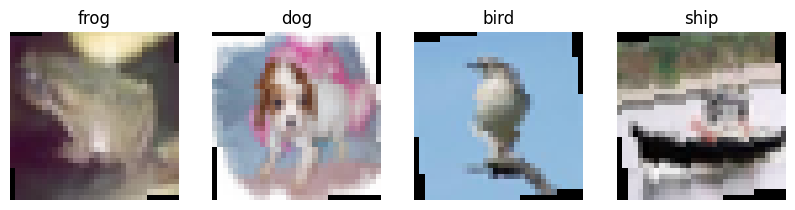

In [133]:
# grab a batch and visualize
dataiter = iter(train_loader)
images, labels = next(dataiter)
show_images(images, labels, class_names, num_images=4)

GENERATING PAIRS FOR SIAMESE NETWORK

In [134]:
# import dataset class
from torch.utils.data import Dataset

# define custom siamese dataset class
class SiameseCIFAR10Dataset(Dataset):
  def __init__(self, dataset, num_pairs_per_class=200):
    self.dataset = dataset # cifar-10 dataset
    self.num_pairs_per_class = num_pairs_per_class
    self.num_classes = 10
    # unzip images and labels from dataset
    self.images, self.labels = zip(*[(img, lbl) for img, lbl in dataset])
    self.labels = torch.tensor(self.labels) # convert labels to tensor
    self.pairs, self.pair_labels = self._generate_pairs() # create pairs

  def _generate_pairs(self):
    pairs = []
    pair_labels = []
    import numpy as np # for random sampling

    # generate positive pairs (same class)
    for class_idx in range(self.num_classes):
      # find indices of images in class
      class_indices = (self.labels == class_idx).nonzero(as_tuple=True)[0]
      # check if enough images for pairs
      if len(class_indices) < 2:
        continue
      # generate pairs
      for _ in range(self.num_pairs_per_class):
        idx1, idx2 = np.random.choice(class_indices, 2, replace=False)
        pairs.append([self.images[idx1], self.images[idx2]])
        pair_labels.append(1)

    # generate negative pairs (diff. class)
    for _ in range(self.num_pairs_per_class * self.num_classes):
      # pick 2 different classes
      class1, class2 = np.random.choice(self.num_classes, 2, replace=False)
      idx1= np.random.choice((self.labels == class1).nonzero(as_tuple=True)[0])
      idx2 = np.random.choice((self.labels == class2).nonzero(as_tuple=True)[0])
      pairs.append([self.images[idx1], self.images[idx2]])
      pair_labels.append(0)

    return pairs, torch.tensor(pair_labels, dtype=torch.float32)

  def __len__(self):
    return len(self.pairs)

  def __getitem__(self, idx):
    img1, img2 = self.pairs[idx] # get the 2 images
    label = self.pair_labels[idx] # get label
    return img1, img2, label


In [135]:
# create Siamese dataset
siamese_trainset = SiameseCIFAR10Dataset(trainset, num_pairs_per_class=1000)

# batch the pairs w/ DataLoader
train_loader = DataLoader(siamese_trainset, batch_size=8, shuffle=True)

In [136]:
# check a batch
dataiter = iter(train_loader)
img1, img2, labels = next(dataiter)
print("Image 1 batch shape:", img1.shape)
print("Image 2 batch shape:", img2.shape)
print("Labels shape:", labels.shape)
print("Total pairs:", len(siamese_trainset))

Image 1 batch shape: torch.Size([8, 3, 32, 32])
Image 2 batch shape: torch.Size([8, 3, 32, 32])
Labels shape: torch.Size([8])
Total pairs: 20000


VISUALIZE PAIRS

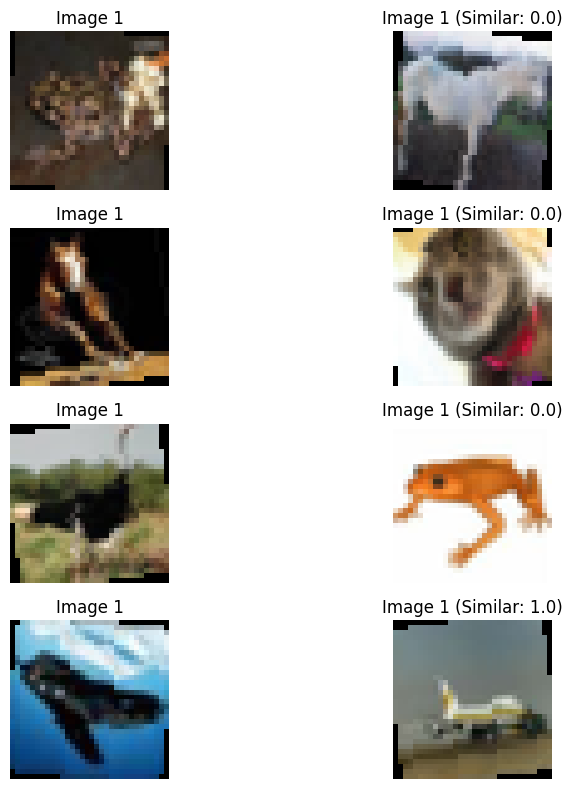

In [137]:
# function to plot Siamese pairs
def show_pairs(img1, img2, labels, class_names, num_pairs=4):
  plt.figure(figsize=(10, 2 * num_pairs)) # widdth 10, height scales w/ pairs
  for i in range(num_pairs):
    # plot first image in pair
    plt.subplot(num_pairs, 2, 2* i + 1) # num_pairs rows, 2 columns
    plt.imshow(img1[i].permute(1, 2, 0).numpy())
    plt.title("Image 1")
    plt.axis('off')

    # second image in pair
    plt.subplot(num_pairs, 2, 2* i + 2) # num_pairs rows, 2 columns
    plt.imshow(img2[i].permute(1, 2, 0).numpy())
    plt.title(f"Image 1 (Similar: {labels[i].item()})")
    plt.axis('off')

  plt.tight_layout() # adjust spacing
  plt.show()

# get a batch from train_loader
dataiter = iter(train_loader)
img1, img2, labels = next(dataiter)

# visualize 4 pairs
show_pairs(img1, img2, labels, class_names, num_pairs=4)


DEFINE SIAMESE NEURAL NETWORK MODEL

In [154]:
# import torch.nn.functional for activation function
import torch.nn.functional as F

# base CNN architecture
class BaseCNN(nn.Module):
  def __init__(self):
    super(BaseCNN, self).__init__()
    # convolutional layers
    self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, padding=1) # input: 3 channels (rbg), output: 32 channels
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # input: 32, output: 64
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    # pooling layer
    self.pool = nn.MaxPool2d(2, 2) # reduces size by half
    # full connected layer
    self.fc1 = nn.Linear(128*4*4, 256) # after pooling twice: 32x32 to 16x16 to 8x8
    self.dropout = nn.Dropout(0.3)

  def forward(self, x):
    # input x [batch_size, 3, 32, 32]
    x = F.relu(self.conv1(x)) # apply conv1 and ReLU
    x = self.pool(x) # pool: 32x32 to 16x16
    x = F.relu(self.conv2(x)) # apply conv2 and ReLU
    x = self.pool(x) # pool: 16x16 to 8x8
    x = F.relu(self.conv3(x)) # apply conv3 to ReLu
    x = self.pool(x) # 8x8 to 4x4
    x = x.view(-1, 128 * 4 * 4) # flatten: [batch_size, 64 * 8 * 8]
    x = self.dropout(x)
    x = F.relu(self.fc1(x))
    return x

# define Siamese Network
class SiameseNetwork(nn.Module):
  def __init__(self):
    super(SiameseNetwork, self).__init__()
    self.base_cnn = BaseCNN() # shared CNN for both images
    self.fc2 = nn.Linear(256, 1) # final layer to predict similarity


  def forward(self, img1, img2):
    # process both images through same CNN
    embedding1 = self.base_cnn(img1) # [batch_size, 128]
    embedding2 = self.base_cnn(img2) # [batch_size, 128]
    # compute absolute difference between embeddings
    distance = torch.abs(embedding1 - embedding2) # [batch_size, 128]
    # predict similarity
    output = torch.sigmoid(self.fc2(distance)) # [batch_size, 1]
    return output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SiameseNetwork().to(device)
print("Model moved to:", device)

# test with batch
img1, img2, labels = next(iter(train_loader))
img1, img2 = img1.to(device), img2.to(device)
output = model(img1, img2)
print("Output shape:", output.shape)
print("Sample output:", output[:2])

Model moved to: cuda
Output shape: torch.Size([8, 1])
Sample output: tensor([[0.4889],
        [0.4899]], device='cuda:0', grad_fn=<SliceBackward0>)


TRAINING MODEL

In [153]:
import torch.optim as optim

# define loss function & optimizer
criterion = nn.BCELoss() # binary cross-entropy loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# training function
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    loss_history = []  # Store losses here
    for epoch in range(num_epochs):
        running_loss = 0.0
        for img1, img2, labels in train_loader:
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(img1, img2)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * img1.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        loss_history.append(epoch_loss)  # append each epoch's loss
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    # Plot the loss curve
    plt.plot(range(1, num_epochs+1), loss_history, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve (BCE, Dropout 0.3, 4000 Pairs)')
    plt.show()
    return loss_history

TESTING PHASE

Epoch [1/15], Loss: 0.6410
Epoch [2/15], Loss: 0.5955
Epoch [3/15], Loss: 0.5695
Epoch [4/15], Loss: 0.5484
Epoch [5/15], Loss: 0.5289
Epoch [6/15], Loss: 0.5125
Epoch [7/15], Loss: 0.4978
Epoch [8/15], Loss: 0.4842
Epoch [9/15], Loss: 0.4714
Epoch [10/15], Loss: 0.4620
Epoch [11/15], Loss: 0.4517
Epoch [12/15], Loss: 0.4411
Epoch [13/15], Loss: 0.4353
Epoch [14/15], Loss: 0.4255
Epoch [15/15], Loss: 0.4191


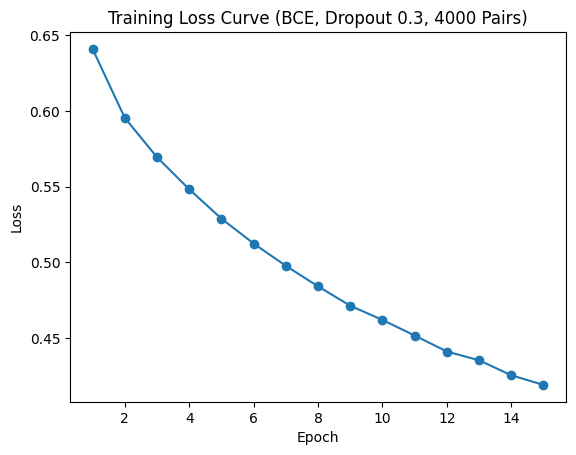

Test Loss: 0.5200, Test Accuracy: 74.58%
Precision: 0.7391, Recall: 0.7600, F1 Score: 0.7494


In [155]:
siamese_testset = SiameseCIFAR10Dataset(testset, num_pairs_per_class=2000)
test_loader = DataLoader(siamese_testset, batch_size=8, shuffle=False)

def evaluate_model(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for img1, img2, labels in test_loader:
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
            outputs = model(img1, img2)
            loss = criterion(outputs.squeeze(), labels)
            running_loss += loss.item() * img1.size(0)

            preds = (outputs.squeeze() >= 0.5).float()
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())

    test_loss = running_loss / len(test_loader.dataset)
    accuracy = 100 * sum([1 for t, p in zip(true_labels, pred_labels) if t == p]) / len(true_labels)

    from sklearn.metrics import precision_score, recall_score, f1_score
    precision = precision_score(true_labels, pred_labels)
    recall = recall_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels)

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    return test_loss, accuracy, precision, recall, f1

siamese_trainset = SiameseCIFAR10Dataset(trainset, num_pairs_per_class=4000)
train_loader = DataLoader(siamese_trainset, batch_size=8, shuffle=True)
model = SiameseNetwork().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)
train_model(model, train_loader, criterion, optimizer, num_epochs=15)

test_loss, accuracy, precision, recall, f1 = evaluate_model(model, test_loader, criterion)

CONFUSION MATRIX

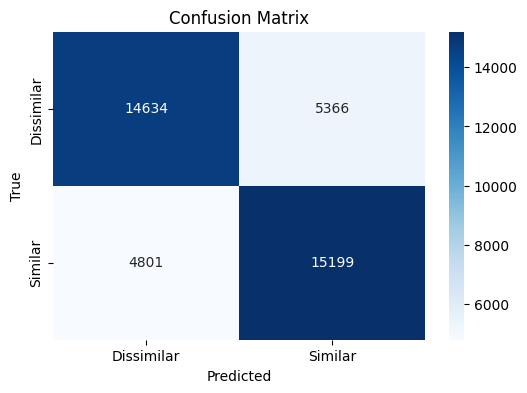

In [156]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, test_loader):
    model.eval()
    true_labels = []
    pred_labels = []
    with torch.no_grad():
        for img1, img2, labels in test_loader:
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
            outputs = model(img1, img2)
            preds = (outputs.squeeze() >= 0.5).float()
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())

    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Dissimilar", "Similar"], yticklabels=["Dissimilar", "Similar"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(model, test_loader)

ROC CURVE AND AOC

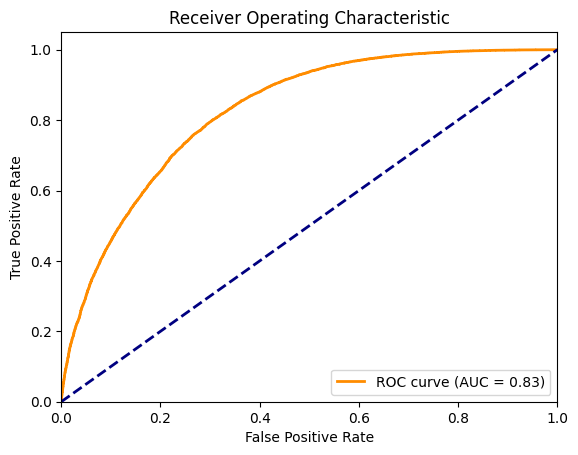

AUC: 0.8253


In [157]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(model, test_loader):
    model.eval()
    true_labels = []
    scores = []
    with torch.no_grad():
        for img1, img2, labels in test_loader:
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
            outputs = model(img1, img2)
            true_labels.extend(labels.cpu().numpy())
            scores.extend(outputs.squeeze().cpu().numpy())

    fpr, tpr, _ = roc_curve(true_labels, scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    return roc_auc

roc_auc = plot_roc_curve(model, test_loader)
print(f"AUC: {roc_auc:.4f}")

EMBEDDING VISUALIZATION

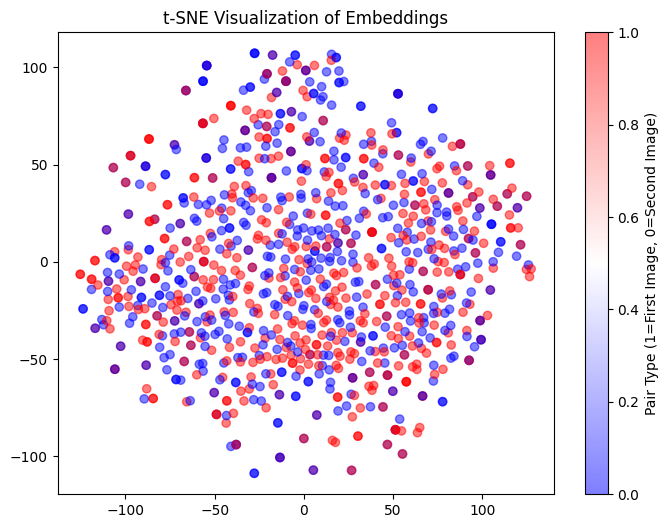

In [158]:
from sklearn.manifold import TSNE
import numpy as np

def visualize_embeddings(model, test_loader, num_samples=500):
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for i, (img1, img2, lbls) in enumerate(test_loader):
            if i * 8 >= num_samples: break
            img1, img2 = img1.to(device), img2.to(device)
            emb1 = model.base_cnn(img1).cpu().numpy()
            emb2 = model.base_cnn(img2).cpu().numpy()
            embeddings.extend(emb1)
            embeddings.extend(emb2)
            labels.extend([1] * len(emb1))  # Arbitrary class for visualization
            labels.extend([0] * len(emb2))

    tsne = TSNE(n_components=2, random_state=42)
    emb_2d = tsne.fit_transform(np.array(embeddings))

    plt.figure(figsize=(8, 6))
    plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=labels, cmap='bwr', alpha=0.5)
    plt.title('t-SNE Visualization of Embeddings')
    plt.colorbar(label='Pair Type (1=First Image, 0=Second Image)')
    plt.show()

visualize_embeddings(model, test_loader)